# Energy Conservation Equation (2D)

## Introduction

In the previous exercise, we studied advection in a one-dimensional problem. We now extend this to two dimensions.  

So far, we have treated advection and diffusion as two separate processes and applied different numerical schemes for each. However, in many geoscientific problems, both transport (advection) and diffusion occur simultaneously. In this case, the energy conservation equation (assuming constant thermal parameters) is given by:

$$
\frac{\partial{T}}{\partial{t}} = -v_x \frac{\partial{T}}{\partial{x}} 
- v_y \frac{\partial{T}}{\partial{y}} 
+ \kappa \left(\frac{\partial^2{T}}{\partial{x^2}} + \frac{\partial^2{T}}{\partial{y^2}}\right),
$$

where $T$ is the temperature [K], $t$ is time [s], $v_i$ is the velocity component in direction $i$ [m/s], and $\kappa = k / (\rho c_p)$ is the thermal diffusivity [m²/s].  

The first two terms on the right-hand side represent **advection**, the middle term represents **diffusion**, and the last term accounts for **heat production**. Together, they describe how the temperature $T$ changes over time $\frac{\partial{T}}{\partial{t}}$ at a given location.  

In this exercise, we use the predefined functions for advection and diffusion from the submodules `GeoModBox.AdvectionEquation.TwoD` and `GeoModBox.HeatEquation.TwoD`. For more details about the discretization and implementation of the 2D advection equation, please refer to the [documentation](https://geosci-ffm.github.io/GeoModBox.jl/dev/man/AdvTwoD/).  

This problem illustrates the coupling of **advection** and **diffusion**, which is fundamental for modeling many geodynamic processes such as mantle convection, plume-lithosphere interaction, and crustal heat transport.


## The Problem

In the following, we investigate how the temperature field evolves over time in a constant two-dimensional velocity field combined with diffusive processes. Different types of initial conditions can be defined.  

For the temperature field:  

1. A circular anomaly with constant background temperature  
2. A Gaussian temperature distribution  
3. A rectangular anomaly with constant background temperature  
4. A linearly increasing temperature profile  

For the velocity field:  

1. A solid-body rotation  
2. An analytically prescribed convection cell  

The initial position of the anomaly is illustrated in Figure 1. In the case of solid-body rotation, the velocities outside the rotation radius are set to zero. This ensures that particles are not advected out of the model domain.  

<img src="../Figures/Exercise07_1.png" alt="drawing" width="500"/> <br>

**Figure 1.** Setup for solid-body rotation with a temperature anomaly.  

These setups serve as benchmark-style test cases to evaluate the accuracy and behavior of advection–diffusion schemes under different flow conditions.

## The Solution

<img src="../Figures/Exercise07_grid.png" alt="drawing" width="500"/> <br>

**Figure 2.** Numerical grid for solving the problem.  

There are several approaches for solving the energy conservation equation numerically, with the discretization method being a crucial choice.  

Here, we focus on a simple method known as *operator splitting*.  

In a first-order approximation, the energy equation can be solved by separating the advection and diffusion operators and treating them independently. In each time step, the procedure is as follows:  

1. Solve the **advection equation** (e.g., using the semi-Lagrangian method):  

$$
\frac{\tilde{T}^{n+1} - T^n}{\Delta{t}} = -v_x \frac{\partial{T}}{\partial{x}} - v_y \frac{\partial{T}}{\partial{y}},
$$  

2. Followed by solving the **diffusion equation** (e.g., with the Crank–Nicolson method):  

$$
\frac{\partial{\tilde{T}}}{\partial{t}} = \kappa \left( \frac{\partial^2{\tilde{T}}}{\partial{x^2}} + \frac{\partial^2{\tilde{T}}}{\partial{y^2}} \right).
$$  

It is important to note that operator splitting introduces a **splitting error**, since advection and diffusion are treated sequentially rather than simultaneously. Nevertheless, this method is widely used because of its conceptual simplicity and flexibility.  

For more information about the discretization and implementation of the 2D advection and diffusion equations, please refer to the [documentation](https://geosci-ffm.github.io/GeoModBox.jl/).  

In the following, we will use the predefined functions for advection and diffusion provided in the submodules `GeoModBox.AdvectionEquation.TwoD` and `GeoModBox.HeatEquation.TwoD`. As always, we start by loading the required modules:

In [1]:
using Plots, Interpolations, ExtendableSparse, LinearAlgebra
using GeoModBox
using GeoModBox.AdvectionEquation.TwoD, GeoModBox.InitialCondition
using GeoModBox.HeatEquation.TwoD, GeoModBox.Tracers.TwoD 
using Base.Threads, Printf
start = time()

1.769067388977804e9

We can now define the advection and diffusion schemes, as well as the initial conditions for temperature and velocity:

In [4]:
# Definition of numerical schemes ====================================== #
# Define Advection Scheme ---
#   Options: 1) upwind, 2) slf (leapfrog), 3) semilag (semi-Lagrangian), 4) tracers
# Define Diffusion Scheme --- 
#   Options: 1) explicit, 2) implicit, 3) CNA (Crank–Nicolson Approximation),
#            4) ADI (Alternating Direction Implicit), 5) dc (defect correction)
FD          =   (Method     = (Adv = :upwind, Diff = :CNA),)

# Define Initial Conditions ---
# Temperature:
#   Options: 1) circle, 2) gaussian, 3) block, 4) linear
# Velocity:
#   Options: 1) RigidBody (solid-body rotation), 2) ShearCell (convection cell)
Ini         =   (T = :circle, V = :RigidBody,) 
# ---------------------------------------------------------------------- #

(T = :circle, V = :RigidBody)

The following parameters define the properties of the visualizations:

In [5]:
# Plot settings ======================================================== #
Pl  =   (
    inc         =   5,                              # Plot increment
    sc          =   1.0 * (100 * (60*60*24*365.15)),# Scaling factor (e.g., time in years)
    Minc        =   1,                              # Marker increment
    Msz         =   0.2,                            # Marker size
)

# Animation settings --------------------------------------------------- #
path        =   string("./Results/") 
anim        =   Plots.Animation(path, String[]) 
filename    =   string("07_2D_EnergyEquation_", Ini.T, "_", Ini.V,
                        "_", FD.Method.Adv, "_", FD.Method.Diff)
save_fig    =   0                                  # Save animation flag
# ---------------------------------------------------------------------- #

0

Next, we define the model geometry and the physical constants:

In [6]:
# Model constants ====================================================== #
M   =   (
    xmin    =   0.0,            # Minimum x-coordinate [m]
    xmax    =   200.0e3,        # Maximum x-coordinate [m]
    ymin    =   0.0,            # Minimum y-coordinate [m]
    ymax    =   200.0e3,        # Maximum y-coordinate [m]
)
# ---------------------------------------------------------------------- #
# Physical parameters ================================================== #
P       = ( 
    k       =   3,              # Thermal conductivity [W/m/K]
    cp      =   1000,           # Specific heat capacity [J/kg/K]
    ρ       =   3200,           # Density [kg/m^3]
    K0      =   273.15,         # Kelvin at 0 °C
    Q0      =   0               # Volumetric heat production [W/m^3]
)
P1      = (
    κ       =   P.k / P.ρ / P.cp,   # Thermal diffusivity [m^2/s]
)
P       =   merge(P, P1)
# ---------------------------------------------------------------------- #

(k = 3, cp = 1000, ρ = 3200, K0 = 273.15, Q0 = 0, κ = 9.374999999999999e-7)

We now proceed with the definition of the numerical parameters …

In [7]:
# Numerical constants ================================================== #
NC  =   (
    x       =   100,        # Number of horizontal cell centers
    y       =   100,        # Number of vertical cell centers
)
NV  =   (
    x       =   NC.x + 1,   # Number of horizontal grid vertices
    y       =   NC.y + 1,   # Number of vertical grid vertices
)
Δ   =   (
    x   =   (abs(M.xmin) + M.xmax) / NC.x,   # Grid spacing in x-direction
    y   =   (abs(M.ymin) + M.ymax) / NC.y,   # Grid spacing in y-direction
)
# ---------------------------------------------------------------------- #

(x = 2000.0, y = 2000.0)

... and the grid coordinates.

In [8]:
# Grid generation ====================================================== #
x   =   (
    c       =   LinRange(M.xmin + Δ.x/2.0, M.xmax - Δ.x/2.0, NC.x),     # Cell centers
    ce      =   LinRange(M.xmin - Δ.x/2.0, M.xmax + Δ.x/2.0, NC.x+2),   # Extended centers (with ghost cells)
    v       =   LinRange(M.xmin, M.xmax, NV.x)                          # Vertices
)
y   =   (
    c       =   LinRange(M.ymin + Δ.y/2.0, M.ymax - Δ.y/2.0, NC.y),     # Cell centers
    ce      =   LinRange(M.ymin - Δ.x/2.0, M.ymax + Δ.x/2.0, NC.y+2),   # Extended centers (with ghost cells)
    v       =   LinRange(M.ymin, M.ymax, NV.y),                         # Vertices
)

# 2D mesh coordinates -------------------------------------------------- #
x1  =   ( 
    c2d     =   x.c .+ 0*y.c',       # Cell centers in 2D
    v2d     =   x.v .+ 0*y.v',       # Vertices in 2D
    vx2d    =   x.v .+ 0*y.ce',      # Velocity points (x-direction)
    vy2d    =   x.ce .+ 0*y.v',      # Velocity points (y-direction)
)
x   =   merge(x, x1)

y1  =   (
    c2d     =   0*x.c .+ y.c',       # Cell centers in 2D
    v2d     =   0*x.v .+ y.v',       # Vertices in 2D
    vx2d    =   0*x.v .+ y.ce',      # Velocity points (x-direction)
    vy2d    =   0*x.ce .+ y.v',      # Velocity points (y-direction)
)
y   =   merge(y, y1)
# ---------------------------------------------------------------------- #

(c = LinRange{Float64}(1000.0, 199000.0, 100), ce = LinRange{Float64}(-1000.0, 201000.0, 102), v = LinRange{Float64}(0.0, 200000.0, 101), c2d = [1000.0 3000.0 … 197000.0 199000.0; 1000.0 3000.0 … 197000.0 199000.0; … ; 1000.0 3000.0 … 197000.0 199000.0; 1000.0 3000.0 … 197000.0 199000.0], v2d = [0.0 2000.0 … 198000.0 200000.0; 0.0 2000.0 … 198000.0 200000.0; … ; 0.0 2000.0 … 198000.0 200000.0; 0.0 2000.0 … 198000.0 200000.0], vx2d = [-1000.0 1000.0 … 199000.0 201000.0; -1000.0 1000.0 … 199000.0 201000.0; … ; -1000.0 1000.0 … 199000.0 201000.0; -1000.0 1000.0 … 199000.0 201000.0], vy2d = [0.0 2000.0 … 198000.0 200000.0; 0.0 2000.0 … 198000.0 200000.0; … ; 0.0 2000.0 … 198000.0 200000.0; 0.0 2000.0 … 198000.0 200000.0])

Here, the data fields are defined using the structures provided by GeoModBox.

In [9]:
# Initializing Arrays ================================================= #
D       =   DataFields(
    Q       =   zeros(Float64,(NC.x,NC.y)),
    T       =   zeros(Float64,(NC.x,NC.y)),
    T0      =   zeros(Float64,(NC.x,NC.y)),
    T_ex    =   zeros(Float64,(NC.x+2,NC.y+2)),
    T_exo   =   zeros(Float64,(NC.x+2,NC.y+2)),
    ρ       =   zeros(Float64,(NC.x,NC.y)),
    cp      =   zeros(Float64,(NC.x,NC.y)),
    vx      =   zeros(Float64,(NV.x,NV.y+1)),
    vy      =   zeros(Float64,(NV.x+1,NV.y)),    
    vxc     =   zeros(Float64,(NC.x,NC.y)),
    vyc     =   zeros(Float64,(NC.x,NC.y)),
    vc      =   zeros(Float64,(NC.x,NC.y)),
    wt      =   zeros(Float64,(NC.x,NC.y)),
    wte     =   zeros(Float64,(NC.x+2,NC.y+2)),
    wtv     =   zeros(Float64,(NV...)),
    Tmax    =   0.0,
    Tmin    =   0.0,
    Tmean   =   0.0,
)
# -------------------------------------------------------------------- #

DataFields([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0;;], [0.0;;], [0.0;;], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0;;], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0;;], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ;

We can now compute the initial temperature and velocity fields using the predefined functions.

In [10]:
# Initial conditions =================================================== #
# Temperature field ---
IniTemperature!(Ini.T, M, NC, D, x, y)
D.Tmax  =   maximum(D.T_ex)                    # Maximum temperature
D.Tmin  =   minimum(D.T_ex)                    # Minimum temperature
D.Tmean =   (D.Tmax[1] + D.Tmin[1]) / 2        # Mean temperature
if FD.Method.Adv == :slf
    D.T_exo .= D.T_ex                          # Store initial field for leapfrog
end

# Heat production and density fields ---
@. D.Q  =   P.Q0                               # Volumetric heat production
@. D.ρ  =   P.ρ                                # Density

# Velocity field ---
# Example: rigid-body rotation (RBR) – maximum velocity = 0.5 cm/a
IniVelocity!(Ini.V, D, 0, NV, Δ, M, x, y)      # Initialize velocity [m/s]

# Upscale velocity (for visualization/testing) ---
D.vx    .*= 20.0
D.vy    .*= 20.0

# Interpolate velocity to cell centers ---
@threads for i = 1:NC.x 
    for j = 1:NC.y
        D.vxc[i,j]  = (D.vx[i,j+1] + D.vx[i+1,j+1]) / 2
        D.vyc[i,j]  = (D.vy[i+1,j] + D.vy[i+1,j+1]) / 2
    end
end
@. D.vc = sqrt(D.vxc^2 + D.vyc^2)              # Velocity magnitude
# ---------------------------------------------------------------------- #

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Since the velocity fields are prescribed and constant, we only need to define the boundary conditions for the temperature.

In [11]:
# Boundary Conditions ================================================ #
# BC     = (type    = (W=:Neumann, E=:Neumann, 
#                    N=:Dirichlet, S=:Dirichlet),
#        val     = (W=zeros(NC.y),E=zeros(NC.y),
#                    N=(D.T_ex[2:end-1,end-1].+D.T_ex[2:end-1,end])./2.0,
#                    S=(D.T_ex[2:end-1,1].+D.T_ex[2:end-1,2])./2.0))
BC     = (type    = (W=:Dirichlet, E=:Dirichlet, 
                    N=:Dirichlet, S=:Dirichlet),
        val     = (W=D.T[1,:],E=D.T[end,:],
                    N=D.T[:,end],S=D.T[:,1]))
# -------------------------------------------------------------------- #

(type = (W = :Dirichlet, E = :Dirichlet, N = :Dirichlet, S = :Dirichlet), val = (W = [600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0  …  600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0], E = [600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0  …  600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0], N = [600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0  …  600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0], S = [600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0  …  600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0]))

Depending on the numerical method chosen to solve the diffusion equation, certain parameters must be defined, such as the coefficient matrices and the right-hand side of the linear systems, or parameters for iterative solvers.  

For more information about the solution methods for the two-dimensional diffusion equation, see the [documentation](https://geosci-ffm.github.io/GeoModBox.jl/dev/man/DiffTwoD/).

In [ ]:
# Linear systems ======================================================= #
if FD.Method.Diff == :implicit || FD.Method.Diff == :CNA
    # Numbering of unknowns (flattened 2D grid into 1D index)
    Num     =   (T = reshape(1:NC.x*NC.y, NC.x, NC.y),)
    ndof    =   maximum(Num.T)                     # Degrees of freedom
    
    if FD.Method.Diff == :CNA
        # Two coefficient matrices for Crank–Nicolson Approach
        K1      =   ExtendableSparseMatrix(ndof, ndof)
        K2      =   ExtendableSparseMatrix(ndof, ndof)
    else
        # Single coefficient matrix for implicit scheme
        K       =   ExtendableSparseMatrix(ndof, ndof)
    end
    rhs     =   zeros(ndof)                        # Right-hand side vector

elseif FD.Method.Diff == :dc
    # Defect-correction iteration parameters
    niter       =   10                             # Max iterations
    ϵ           =   1e-10                          # Convergence tolerance
    
    # Physical fields
    @. D.ρ      =   P.ρ
    @. D.cp     =   P.cp
    
    # Thermal conductivity on cell faces
    k           =   (x = zeros(NC.x+1, NC.y),
                     y = zeros(NC.x,   NC.y+1))
    @. k.x      =   P.k
    @. k.y      =   P.k
    
    # Numbering of unknowns
    Num         =   (T = reshape(1:NC.x*NC.y, NC.x, NC.y),)
    ndof        =   maximum(Num.T)
    
    # System matrix and residual
    K           =   ExtendableSparseMatrix(ndof, ndof)
    R           =   zeros(NC.x, NC.y)              # Residual field
    
    # Temperature gradients at faces
    ∂T          =   (∂x = zeros(NC.x+1, NC.y),
                     ∂y = zeros(NC.x,   NC.y+1))
    
    # Heat fluxes at faces
    q           =   (x  = zeros(NC.x+1, NC.y),
                     y  = zeros(NC.x,   NC.y+1))
end
# ---------------------------------------------------------------------- #


We can now determine the time-integration parameters. Note: the time step must satisfy the most restrictive constraint from both the advection and diffusion schemes.

In [13]:
# Time ================================================================ #
T   =   ( 
    tmax    =   [0.0],     # Maximum simulation time [s]
    Δfacc   =   1.0,       # Courant time factor, i.e., dtfac * dt_courant
    Δfacd   =   1.0,       # Diffusion time factor, i.e., dtfac * dt_diff 
    Δ       =   [0.0],     # Final chosen time step
    Δc      =   [0.0],     # Courant time step (advection stability limit)
    Δd      =   [0.0],     # Diffusion time step (stability criterion)
)

# Maximum runtime: based on a characteristic advection time scale
# here approximated by π * (domain width – one cell) / maximum velocity
T.tmax[1]   =   π * ((M.xmax - M.xmin) - Δ.x) / maximum(D.vc)   # [s]

# Courant stability condition (for advection)
T.Δc[1]     =   T.Δfacc * minimum((Δ.x, Δ.y)) / 
                    (sqrt(maximum(abs.(D.vx))^2 + maximum(abs.(D.vy))^2))

# Diffusion stability condition (explicit scheme)
T.Δd[1]     =   T.Δfacd * (1.0 / (2.0 * P.κ * (1.0/Δ.x^2 + 1.0/Δ.y^2)))

# Final time step: take the most restrictive (advection or diffusion)
T.Δ[1]      =   minimum([T.Δd[1], T.Δc[1]])

# Total number of time steps
nt          =   ceil(Int, T.tmax[1] / T.Δ[1])
# --------------------------------------------------------------------- #

440

In the case where temperature is advected using tracers, the next step is to initialize the tracers.

In [12]:
# Tracer Advection ===================================================== #
if FD.Method.Adv == :tracers 
    # Tracer Initialization ---
    nmx,nmy     =   3,3
    noise       =   1
    nmark       =   nmx*nmy*NC.x*NC.y
    Aparam      =   :thermal
    MPC         =   (
        c       =   zeros(Float64,(NC.x,NC.y)),
        v       =   zeros(Float64,(NV.x,NV.y)),
        th      =   zeros(Float64,(nthreads(),NC.x,NC.y)),
        thv     =   zeros(Float64,(nthreads(),NV.x,NV.y)),
    )
    MAVG        = (
        PC_th   =   [similar(D.wte) for _ = 1:nthreads()],  # per thread
        PV_th   =   [similar(D.wtv) for _ = 1:nthreads()],   # per thread
        wte_th  =   [similar(D.wte) for _ = 1:nthreads()],  # per thread
        wtv_th  =   [similar(D.wtv) for _ = 1:nthreads()],  # per thread
    )
    Ma      =   IniTracer2D(Aparam,nmx,nmy,Δ,M,NC,noise,0,0)
    # RK4 weights ---
    rkw     =   1.0/6.0*[1.0 2.0 2.0 1.0]   # for averaging
    rkv     =   1.0/2.0*[1.0 1.0 2.0 2.0]   # for time stepping
    # Interpolate on centroids ---
    @threads for k = 1:nmark
        Ma.T[k] =   FromCtoM(D.T_ex, k, Ma, x, y, Δ, NC)
    end
    # Count marker per cell ---
    CountMPC(Ma,nmark,MPC,M,x,y,Δ,NC,NV)
end
# ---------------------------------------------------------------------- #


Let us now plot the initial conditions.

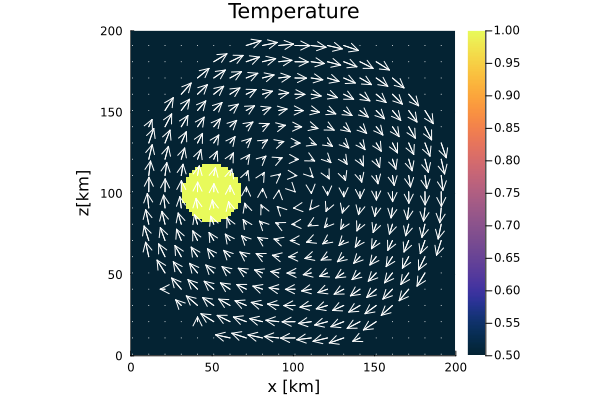

In [14]:
# Visualize initial condition ======================================== #
p = heatmap(x.c./1e3 , y.c./1e3, (D.T./D.Tmax[1])', 
    color=:thermal, colorbar=true, aspect_ratio=:equal, 
    xlabel="x [km]", ylabel="z[km]", 
    title="Temperature", 
    xlims=(M.xmin./1e3, M.xmax./1e3), ylims=(M.ymin./1e3, M.ymax./1e3),
    clim=(0.5, 1.0))
quiver!(p,x.c2d[1:Pl.inc:end,1:Pl.inc:end]./1e3,
        y.c2d[1:Pl.inc:end,1:Pl.inc:end]./1e3,
        quiver=(D.vxc[1:Pl.inc:end,1:Pl.inc:end].*Pl.sc,
            D.vyc[1:Pl.inc:end,1:Pl.inc:end].*Pl.sc),        
        color="white")
if save_fig == 1
    Plots.frame(anim)
elseif save_fig == 0
    display(p)
end
# -------------------------------------------------------------------- #

We can now start the time loop. Within each iteration, we first solve the advection equation, followed by the diffusion equation. The temperature field is then plotted at selected time steps.

In [ ]:
# Time loop ============================================================ #
for i = 2:nt
    @printf("Time step: #%04d\n ", i)
    
    # Solve advection equation ----------------------------------------- #
    if FD.Method.Adv == :upwind
        upwindc2D!(D.T, D.T_ex, D.vxc, D.vyc, NC, T.Δ[1], Δ.x, Δ.y)

    elseif FD.Method.Adv == :slf
        slfc2D!(D.T, D.T_ex, D.T_exo, D.vxc, D.vyc, NC, T.Δ[1], Δ.x, Δ.y)

    elseif FD.Method.Adv == :semilag
        semilagc2D!(D.T, D.T_ex, D.vxc, D.vyc, [], [], x, y, T.Δ[1])

    elseif FD.Method.Adv == :tracers
        # NOTE: Remove NaNs in D.T before interpolating from C→M!
        # Interpolate from grid to tracers ------------------------------ #
        @threads for k = 1:nmark
            Ma.T[k] = FromCtoM(D.T_ex, k, Ma, x, y, Δ, NC)
        end
        # Advect tracers ---
        AdvectTracer2D(Ma,nmark,D,x,y,T.Δ[1],Δ,NC,rkw,rkv)
        CountMPC(Ma,nmark,MPC,M,x,y,Δ,NC,NV)
        
        # Interpolate temperature from tracers to grid ---
        Markers2Cells(Ma,nmark,MAVG.PC_th,D.T_ex,MAVG.wte_th,D.wte,x,y,Δ,Aparam,0)           
        D.T     .=  D.T_ex[2:end-1,2:end-1]
    end

    # Solve diffusion equation ----------------------------------------- #
    if FD.Method.Diff == :explicit
        ForwardEuler2Dc!(D, P.κ, Δ.x, Δ.y, T.Δ[1], D.ρ, P.cp, NC, BC)

    elseif FD.Method.Diff == :implicit
        BackwardEuler2Dc!(D, P.κ, Δ.x, Δ.y, T.Δ[1], D.ρ, P.cp, NC, BC, rhs, K, Num)

    elseif FD.Method.Diff == :CNA
        CNA2Dc!(D, P.κ, Δ.x, Δ.y, T.Δ[1], D.ρ, P.cp, NC, BC, rhs, K1, K2, Num)

    elseif FD.Method.Diff == :ADI
        ADI2Dc!(D, P.κ, Δ.x, Δ.y, T.Δ[1], D.ρ, P.cp, NC, BC)

    elseif FD.Method.Diff == :dc
        D.T0 .= D.T
        for iter = 1:niter
            # Evaluate residual ---------------------------------------- #
            ComputeResiduals2D!(R, D.T, D.T_ex, D.T0, ∂T, q, D.ρ, D.cp, k, BC, Δ, T.Δ[1])
            # @printf("||R|| = %1.4e\n", norm(R)/length(R))
            norm(R)/length(R) < ϵ ? break : nothing

            # Assemble linear system ----------------------------------- #
            K  = AssembleMatrix2D(D.ρ, D.cp, k, BC, Num, NC, Δ, T.Δ[1])

            # Solve for temperature correction (Cholesky factorization) -#
            Kc = cholesky(K.cscmatrix)
            # Back substitution ---------------------------------------- #
            δT = -(Kc \ R[:])

            # Update temperature --------------------------------------- #
            @. D.T += δT[Num.T]
        end        
    end

    # Plot solution ----------------------------------------------------- #
    if mod(i, 10) == 0 || i == nt
        p = heatmap(x.c ./ 1e3, y.c ./ 1e3, (D.T ./ D.Tmax[1])',
            color=:thermal, colorbar=true, aspect_ratio=:equal, 
            xlabel="x [km]", ylabel="z [km]", 
            title="Temperature", 
            xlims=(M.xmin ./ 1e3, M.xmax ./ 1e3), ylims=(M.ymin ./ 1e3, M.ymax ./ 1e3),
            clim=(0.5, 1.0))

        quiver!(p,
                x.c2d[1:Pl.inc:end, 1:Pl.inc:end] ./ 1e3,
                y.c2d[1:Pl.inc:end, 1:Pl.inc:end] ./ 1e3,
                quiver=(D.vxc[1:Pl.inc:end, 1:Pl.inc:end] .* Pl.sc,
                        D.vyc[1:Pl.inc:end, 1:Pl.inc:end] .* Pl.sc),
                color="white")

        if save_fig == 1
            Plots.frame(anim)
        elseif save_fig == 0
            display(p)
        end
    end
end # End time loop ----------------------------------------------------- #
# ---------------------------------------------------------------------- #


Finally, we want to save the animation.

In [ ]:
# Save Animation ===================================================== #
if save_fig == 1
    # Write the frames to a GIF file
    Plots.gif(anim, string( path, filename, ".gif" ), fps = 15)
    foreach(rm, filter(startswith(string(path,"00")), readdir(path,join=true)))
elseif save_fig == 0
    display(plot(p))
end
# -------------------------------------------------------------------- #
stop = time()
println(stop-start)